In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm

#from matplotlib import rc, rcParams

from scipy.integrate import odeint
from HTC_utils import *

In [2]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        

In [4]:
rc = {"font.family" : "DejaVu Serif", 
      "mathtext.fontset" : "dejavuserif",
      "xtick.labelsize": 18,
      "ytick.labelsize": 18,
      'axes.labelsize': 26}
plt.rcParams.update(rc)

#plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

In [5]:
W = np.loadtxt('connectome.txt')
W = normalize(W)

r1 = 0.1
r2 = 0.1

Tminus = r1 * r2 / (r1 + r2 + r1*r2)
Tplus = r2 / (2*r2 +1)

xplus = Tplus
yplus = Tplus / r2

xminus = Tminus
yminus = Tminus / r2

print(Tminus)
print(Tplus)

0.04761904761904762
0.08333333333333334


# * Useful functions

In [6]:
# Define function for string formatting of scientific notation
def sci_notation(num, decimal_digits=1, precision=None, exponent=None):
    """
    Returns a string representation of the scientific
    notation of the given number formatted for use with
    LaTeX or Mathtext, with specified number of significant
    decimal digits and precision (number of decimal digits
    to show). The exponent to be used can also be specified
    explicitly.
    """
    if num==0:
        return str(0)
    if exponent is None:
        exponent = int(np.floor(np.log10(abs(num))))
    coeff = round(num / float(10**exponent), decimal_digits)
    if precision is None:
        precision = decimal_digits

    return r"${0:.{2}f}\cdot10^{{{1:d}}}$".format(coeff, exponent, precision)

def load_results(name):        
    Trange = np.load('data/'+str(name)+'_Trange.npy')
    A = np.load('data/'+str(name)+'_A.npy')
    sigmaA = np.load('data/'+str(name)+'_sigmaA.npy')
    acorr = np.load('data/'+str(name)+'_acorr.npy')
    f = np.load('data/'+str(name)+'_f.npy')
    spectra = np.load('data/'+str(name)+'_spectra.npy')
    
    return (Trange, A, sigmaA, acorr, f, spectra)

def Psup(w, r1, r2):
    return ( (2*r2 * (1 + r2 + r2**2 + w**2))
           / (1 + 2*r2) / ( (1 + 2*r2)**2 + (2 + r2**2)*w**2 + w**4) )

def Psub(w,r1,r2):
    return ( 2*r1*r2 * (r1**2 + r1*r2 + r2**2 + w**2) /
          (r1 + r2 + r1*r2)  / ((r1 + r2 + r1*r2)**2 + (1 + r1**2 + r2**2)*w**2 + w**4 ))

def my_power_spectrum(x, dt, nperseg=int(1e4)):
    return signal.welch(x, nperseg = nperseg, fs = 1/dt, scaling = 'density')

def w_max(r1, r2):
    return np.sqrt( (1+r1+r2)*np.sqrt(r1*r2) - r1**2 - r2**2 - r1*r2 )

def get_dynamical_range(Exc, stimuli, low=0.1, high=0.9):
    '''
    Compute the dynamical range
    '''
    delta = np.zeros(len(Exc))
    
    for i in range(len(Exc)):
        # Original matrix
        
        # Get A90 and A10
        Amax, Amin = np.max(Exc[i]), np.min(Exc[i])
        A10, A90 = (Amax-Amin)*low + Amin, (Amax-Amin)*high + Amin
        # Get corresponent index
        s10 = np.where( (A10 > Exc[i][:-1])*(A10 < Exc[i][1:]) )[0][-1]
        s90 = np.where( (A90 > Exc[i][:-1])*(A90 < Exc[i][1:]) )[0][0]
        # Get the s value by linear interpolation
        s10 = (stimuli[s10]-stimuli[s10+1]) / (Exc[i][s10]-Exc[i][s10+1]) * (A10 - Exc[i][s10+1]) + stimuli[s10+1]
        s90 = (stimuli[s90]-stimuli[s90+1]) / (Exc[i][s90]-Exc[i][s90+1]) * (A90 - Exc[i][s90+1]) + stimuli[s90+1]
        
        # Dynamical range
        delta[i] = 10*np.log10(s90 / s10)
        
    return delta

# Phase diagram

In [4]:
def arrowed_spines(fig, ax):

    xmin, xmax = ax.get_xlim() 
    ymin, ymax = ax.get_ylim()

    # removing the default axis on all sides:
    for side in ['bottom','right','top','left']:
        ax.spines[side].set_visible(False)

    # removing the axis ticks
    plt.xticks([]) # labels 
    plt.yticks([])
    ax.xaxis.set_ticks_position('none') # tick markers
    ax.yaxis.set_ticks_position('none')

    # get width and height of axes object to compute 
    # matching arrowhead length and width
    dps = fig.dpi_scale_trans.inverted()
    bbox = ax.get_window_extent().transformed(dps)
    width, height = bbox.width, bbox.height

    # manual arrowhead width and length
    hw = 1./20.*(ymax-ymin) 
    hl = 1./20.*(xmax-xmin)
    lw = 1.5 # axis line width
    ohg = 0.1 # arrow overhang

    # compute matching arrowhead length and width
    yhw = hw/(ymax-ymin)*(xmax-xmin)* height/width 
    yhl = hl/(xmax-xmin)*(ymax-ymin)* width/height

    # draw x and y axis
    ax.arrow(xmin, 0, xmax-xmin, 0., fc='k', ec='k', lw = lw, 
             head_width=hw, head_length=hl, overhang = ohg, 
             length_includes_head= True, clip_on = False) 

    ax.arrow(0, ymin, 0., ymax-ymin, fc='k', ec='k', lw = lw, 
             head_width=hw, head_length=hl, overhang = ohg,
             length_includes_head= True, clip_on = False)

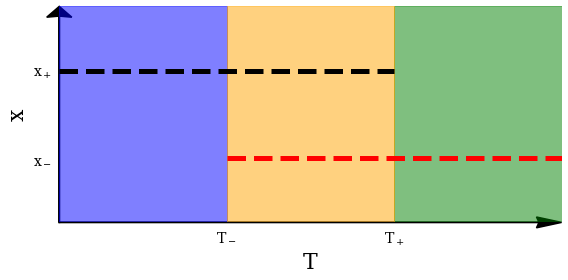

In [6]:
minor = 2/6
major = 4/6

lw = 5

fig = plt.figure(figsize=(8,4))

ax = plt.subplot(111)

arrowed_spines(fig, ax)

ax.set_xlabel('T')
ax.set_ylabel('x')

# T

plt.xticks([minor, major], [r'$\mathrm{T}_-$', r'$\mathrm{T}_+$'])

# X

plt.yticks([0.7, 0.3], [r'$\mathrm{x}_+$', r'$\mathrm{x}_-$'])

plt.axhline(y=0.7, xmin=0., xmax=major, c='k', ls='--', lw=lw)
plt.axhline(y=0.3, xmin=minor, xmax=1, c='r', ls='--', lw=lw)

ax.axvspan(0, minor, alpha=0.5, color='b')
ax.axvspan(major, 1, alpha=0.5, color='g')
ax.axvspan(minor, major, alpha=0.5, color='orange')

#ax.text(0.05, 0.4, '1 fixed point', size=13)
#ax.text(0.75, 0.4, '1 fixed point', size=13)
#ax.text(0.4, 0.6, '2 fixed points', size=13)

plt.xlim([0,1])
plt.ylim([0,1])

#plt.show()
plt.tight_layout()
plt.savefig("figures/test.pdf")

# Type of equilibria

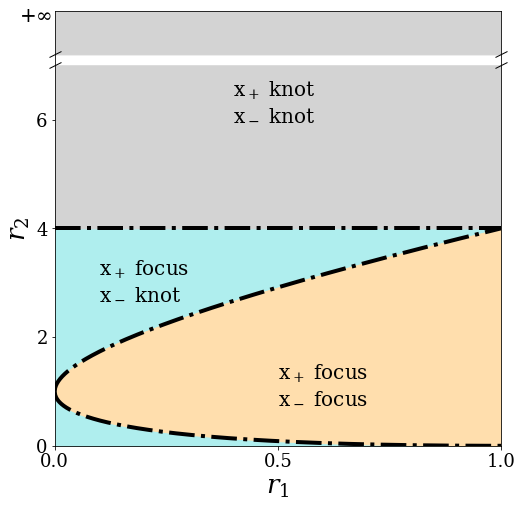

In [81]:
x_lim = 1
y_lim = 8

y_bar = 4

plt.figure(figsize=(8,8))

x = np.linspace(0,x_lim,1000)
y1 = x - 2*np.sqrt(x) +1
y2 = x + 2*np.sqrt(x) +1

plt.plot(x, y1, '-.', c='k', lw=4)
plt.plot(x, y2, '-.', c='k', lw=4)
plt.axhline(y_bar, c='k', lw=4, ls='-.')


plt.fill_between(x,y1, color='paleturquoise')
plt.fill_between(x,y2,y_bar, where= y2<y_bar, color='paleturquoise')

plt.fill_between(x,y1,y_bar, where=y2>y_bar, color='navajowhite')
plt.fill_between(x,y1,y2, where=y2<y_bar, color='navajowhite')

plt.fill_between(x,y_bar,7, where=(y2<y_bar), color='lightgrey')
plt.fill_between(x,7+0.2,y_lim, where=(y2<y_bar), color='lightgrey')


plt.text(.5,.8,'$\mathrm{x}_+$ focus\n$\mathrm{x}_-$ focus', size=20)

plt.text(.4,6.,'$\mathrm{x}_+$ knot\n$\mathrm{x}_-$ knot', size=20)

plt.text(0.1,2.7,'$\mathrm{x}_+$ focus\n$\mathrm{x}_-$ knot', size=20)

plt.xlabel(r'$r_1$')
plt.ylabel(r'$r_2$')

plt.xlim([0,1])
plt.ylim([0,y_lim])

d = .5
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)

dd = 0.2
xx = 7.

plt.plot([0, 1], [xx, xx], **kwargs)
plt.plot([0, 1], [xx+dd, xx+dd], **kwargs)

plt.locator_params(nbins=3)
plt.yticks(np.arange(0,7,2))
plt.text(-0.08,7.8, r'+$\infty$', size=20)

#plt.show()
plt.savefig("figures/params_space.pdf")

# Examples of trajectories

In [82]:
N = int(5e4)
dt = 0.01
steps = int(5e3)

Ts = [0.6*Tminus, Tminus + 0.5*(Tplus-Tminus), 1.5*Tplus]
titles = [r'$T<T_-$', r'$T_-<T<T_+$', r'$T>T_+$']

In [ ]:
res = []

# Run model
for i, T in enumerate(Ts):
    print(i)
    x, y = run_htc_single(None, xplus, yplus, T, r1, r2, dt, steps, N=N, runs=30)
    
    res.append(x)

In [10]:
for i, x in enumerate(res):
    np.save('results/traj_sample_'+str(i)+'.npy', x)

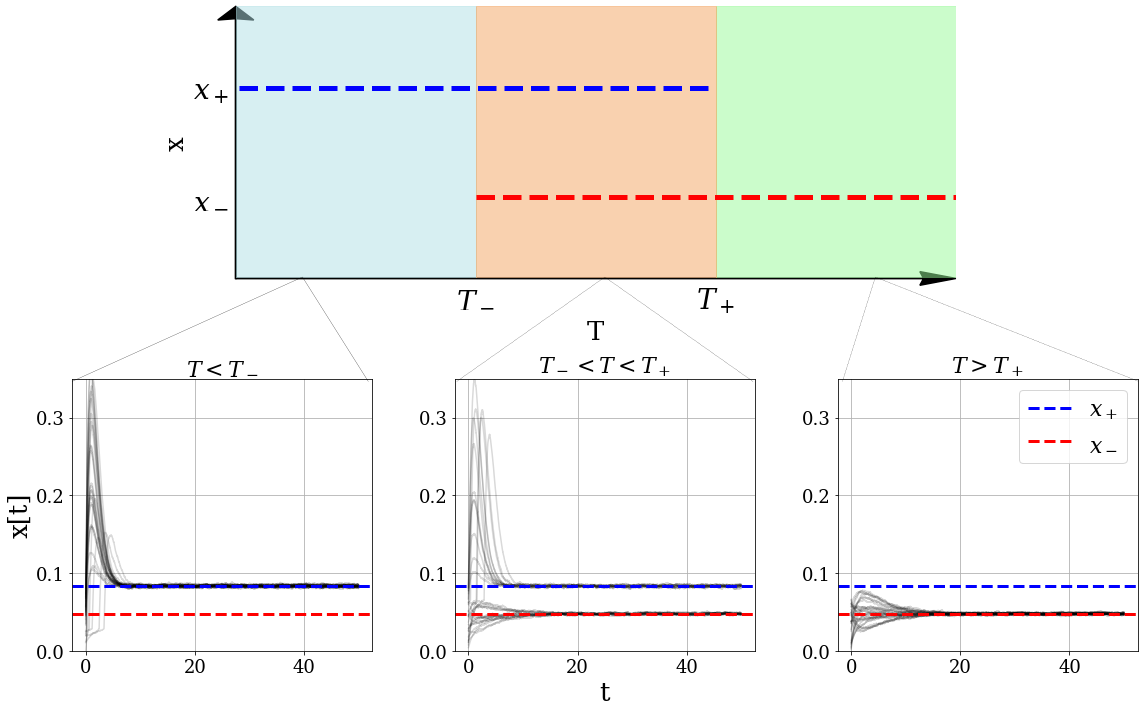

In [84]:
minor = 2/6
major = 4/6

size = 28
lw = 5

fig = plt.figure(figsize=(16,10))

widths = [0.9, 8, 1.1]
heights = [1, 1]
spec = fig.add_gridspec(ncols=3, nrows=2, width_ratios=widths,
                          height_ratios=heights)

# DIAGRAM EQUILIBRIA
#ax1 = plt.subplot(2, 1, 1)
ax1 = fig.add_subplot(spec[0,1])

arrowed_spines(fig, ax1)

ax1.set_xlabel('T')
ax1.set_ylabel('x')

plt.xticks([minor, major], [r'$T_-$', r'$T_+$'], size=size)

plt.yticks([0.7, 0.3], [r'$x_+$', r'$x_-$'], size=size)

plt.axhline(y=0.7, xmin=0.005, xmax=major, c='blue', ls='--', lw=lw)
plt.axhline(y=0.3, xmin=minor, xmax=1, c='r', ls='--', lw=lw)

ax1.axvspan(0, minor, alpha=0.5, color='powderblue')
ax1.axvspan(major, 1, alpha=0.5, color='palegreen')
ax1.axvspan(minor, major, alpha=0.5, color='sandybrown')#navajowhite

plt.xlim([0,1])
plt.ylim([0,1])

### TRAJECTORIES
size = 22

for i, T in enumerate(Ts):
    #print('T='+str(T))

    #x, y = run_htc_single(None, xplus, yminus, T, r1, r2, dt, steps, N=N, runs=30)
        
    ax2 = plt.subplot(2, 3, i+4)
    
    plt.locator_params(nbins=5)
        
    for series in res[i]:
        plt.plot(np.arange(0,steps)*dt, series, alpha=0.15, c='k')
        
    plt.axhline(xplus, ls='--', c='blue', label=r'$x_+$', lw=3)
    plt.axhline(xminus, ls='--', c='r', label=r'$x_-$', lw=3)
        
    plt.title(titles[i], size=size)
    
    plt.ylim([0,.35])
        
    if i == 0:
        plt.ylabel('x[t]')
            
    if i == len(Ts)-2:
        plt.xlabel('t')
        
    if i == len(Ts)-1:
        plt.legend(fontsize=size)
    
    #plt.xticks(fontsize=size-8)
    #plt.yticks(fontsize=size-8)
    plt.grid()
    
    
### CONNECTION PATCHES
ax3 = plt.figure(1).add_subplot(111)

lw = 0.25

up = 0.58
down = 0.418

xleft = 0
xright = 0.278
delta = 0.00

k = 7/9
ax3.plot([xleft,xright*k - delta],[down,up],'-', c='k', lw=lw)
ax3.plot([xright,xright*k + delta],[down,up],'-', c='k', lw=lw)

offset = 0.361
k = 0.5
ax3.plot([xleft + offset, xright*k - delta + offset],[down,up],'--', c='k', lw=lw)
ax3.plot([xright + offset, xright*k + delta + offset],[down,up],'--', c='k', lw=lw)

offset = 0.723
k = 1/9
ax3.plot([xleft + offset, xright*k - delta + offset],[down,up],'--', c='k', lw=lw)
ax3.plot([xright + offset, xright*k + delta + offset],[down,up],'--', c='k', lw=lw)

ax3.set_xlim([0,1])
ax3.set_ylim([0,1])
ax3.axis("off")

plt.tight_layout()
#plt.show()
#plt.savefig("figures/diagram_trajectories.pdf")
#plt.savefig("figures/diagram_trajectories.jpg", dpi = 200, bbox_inches = 'tight')
plt.savefig("figures/diagram_trajectories.png")

# Example of power spectrum

In [7]:
N = int(1e4)
dt = 0.01
steps = int(5e5)

Ts = [0.5*Tminus, Tminus + 0.5*(Tplus-Tminus), 2.*Tplus]
titles = [r'$T<T_-$', r'$T_-<T<T_+$', r'$T>T_+$']

In [50]:
res_spec_2 = []

# Run model
for i, T in enumerate(Ts):
    print(i)
    
    x, y = run_htc_single(None, xplus, yplus, T, r1, r2, dt, steps, N=N, runs=30, eq_steps=int(50/dt))
    
    res_spec_2.append(x)

0
1
2


In [67]:
for i, res in enumerate(res_spec_2):
    np.save('results/N_'+str(N)+'_dt_'+str(dt)+'_steps_'+str(steps)+'_T_'+str(Ts[i])+'.npy', res)

In [8]:
res_spec = []

for i, T in enumerate(Ts):
    tmp = np.load('results/N_'+str(N)+'_dt_'+str(dt)+'_steps_'+str(steps)+'_T_'+str(Ts[i])+'.npy')
    res_spec.append(tmp)

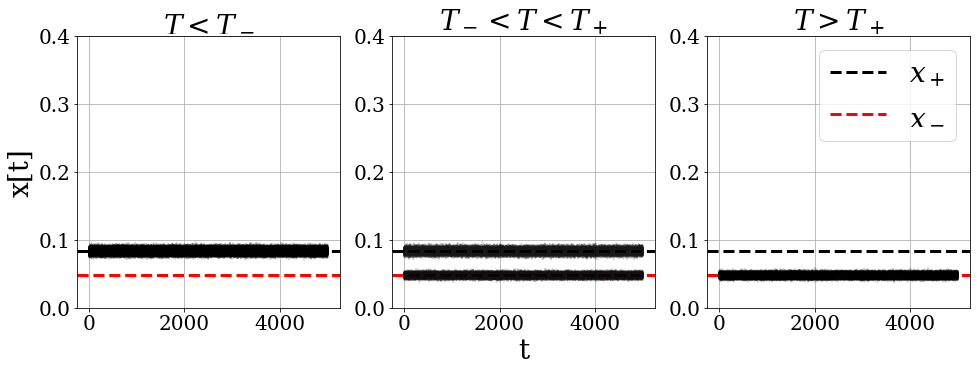

In [69]:
size = 28

plt.figure(figsize=(16,5))

for i, T in enumerate(Ts):
    #print('T='+str(T))

    #x, y = run_htc_single(None, xplus, yminus, T, r1, r2, dt, steps, N=N, runs=30)
        
    plt.subplot(1, len(Ts), i+1)
    
    plt.locator_params(nbins=5)
    
    plt.axhline(xplus, ls='--', c='k', label=r'$x_+$', lw=3)
    plt.axhline(xminus, ls='--', c='r', label=r'$x_-$', lw=3)
        
    for series in res_spec[i]:
        plt.plot(np.arange(0,steps)*dt, series, alpha=0.15, c='k')
        
    plt.title(titles[i], size=size)
    
    plt.ylim([0,.4])
        
    if i == 0:
        plt.ylabel('x[t]', size=size)
            
    if i == len(Ts)-2:
        plt.xlabel('t', size=size)
        
    if i == len(Ts)-1:
        plt.legend(fontsize=size)
    
    plt.xticks(fontsize=size-8)
    plt.yticks(fontsize=size-8)
    plt.grid()
        
#plt.show()
#plt.savefig("figures/trajectories.pdf")

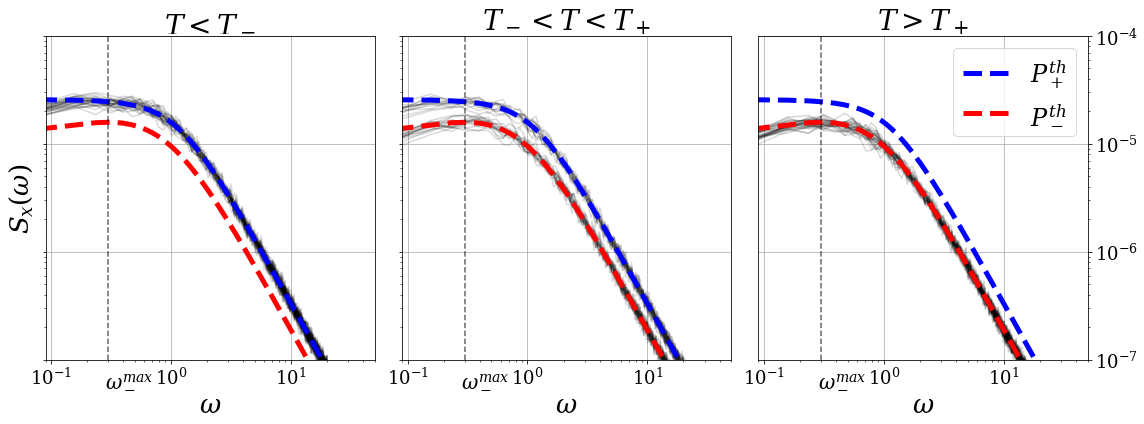

In [10]:
size = 28
lw=5

plt.figure(figsize=(16,6))

for i, T in enumerate(Ts):

    ax = plt.subplot(1, len(Ts), i+1)
    
    for x in res_spec[i]:
        f, S = my_power_spectrum(x, dt, nperseg=int(8e3))
    
        plt.plot(2*np.pi*f, S, c='k', alpha=0.15)

    plt.plot(2*np.pi*f, Psup(2*np.pi*f,r1,r2) / N / 0.5, '--', label=r'$P_+^{th}$', lw=lw, c='blue')
    plt.plot(2*np.pi*f, Psub(2*np.pi*f,r1,r2) / N / 0.5, '--', label=r'$P_-^{th}$', lw=lw, c='r')
        
    plt.xlabel(r'$\omega$')
    if i==0:
        plt.ylabel(r'$S_x(\omega)$')
        
    plt.title(titles[i], size=size)
    plt.locator_params(nbins=4)
    plt.xscale('log')
    plt.yscale('log')
    
    plt.axvline(w_max(r1, r2), c='k', ls='--', alpha=0.6)
    
    ax.text(0.18, -0.08, r'$\omega_-^{max}$',transform=ax.transAxes, size=20)
    
    #plt.text(-7, 1, 'coap')
    
    #plt.xticks(fontsize=size-14)
    #plt.yticks(fontsize=size-14)
    
    if i < len(Ts)-1:
        ax.yaxis.set_ticklabels([])
    else:
        ax.yaxis.tick_right()
    
    plt.grid()
    
    if i==len(Ts)-1:
        plt.legend(fontsize=size-4)
        
    plt.xlim([9e-2, 5e1])
    plt.ylim([1e-7, 1e-4])

#plt.show()
plt.tight_layout()
plt.savefig("figures/spectrum.pdf")

# Hysteresis

In [300]:
Ns = [5e2, 1e3, 5e3, 1e4, 2e4, 3e4, 4e4, 5e4]
results = []

for N in Ns:
    name = 'N_'+str(int(N))+'_p_1_r1_'+str(r1)+'_r2_'+str(r2)
    res = load_results(name)
    results.append(res)

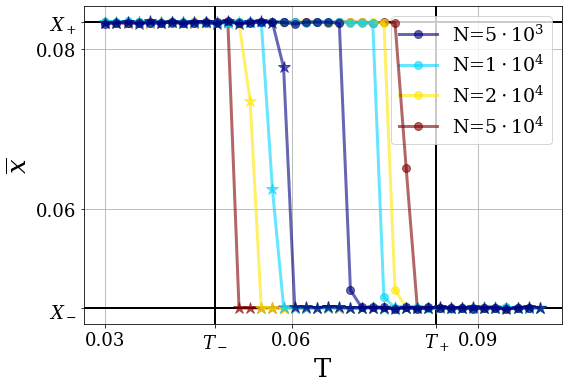

In [304]:
size = 26
alpha = 0.6

alpha_2 = 0.4

cmap = plt.cm.get_cmap('jet', len(results))

#plt.figure(figsize=(10,6.5))
plt.figure(figsize=(8,5.5))

#plt.axhline(xplus, ls='--', c='blue', lw=3, zorder=1, alpha=alpha)
#plt.axhline(xminus, ls='--', c='red', lw=3, zorder=1, alpha=alpha)

#plt.axvline(Tminus, ls='-.', c='red', lw=3, zorder=1, alpha=alpha_2)
#plt.axvline(Tplus, ls='-.', c='blue', lw=3, zorder=1, alpha=alpha_2)

plt.axhline(xplus, c='k', lw=2)
plt.axhline(xminus, c='k', lw=2)

plt.axvline(Tminus, c='k', lw=2)
plt.axvline(Tplus, c='k', lw=2)

to_print = [2, 3, 4, 7]

N_to_print = [Ns[i] for i in to_print]
results_to_print = [results[i] for i in to_print]
cmap = plt.cm.get_cmap('jet', len(results_to_print))

for i, res in enumerate(results_to_print):
    # increasing T with dots
    plt.plot(res[0][:len(res[0])//2], res[1][:len(res[0])//2], 'o-', label='N='+sci_notation(N_to_print[i], decimal_digits=0), c=cmap(i), ms=8, lw=3, alpha=alpha, zorder=100-i)
    # decreasing T with stars
    plt.plot(res[0][len(res[0])//2:], res[1][len(res[0])//2:], '*-', c=cmap(i), ms=12, lw=3, alpha=alpha, zorder=100-i)
    
plt.xlabel('T')
plt.ylabel(r'$\overline{x}$')

xpos = np.arange(0.06, 0.09, 0.02)
xtick = np.round(xpos,3).astype(str)
xpos = list(xpos) + [xminus, xplus]
xtick = list(xtick) + [r'$X_-$', r'$X_+$']

ypos = np.arange(0.03, 0.11, 0.03)
ytick = np.round(ypos,3).astype(str)
ypos = list(ypos) + [Tminus, Tplus]
ytick = list(ytick) + [r'$T_-$', r'$T_+$']

plt.yticks(ticks = xpos, labels=xtick)
plt.xticks(ticks = ypos, labels=ytick)

#plt.yticks(fontsize=size-8)
#plt.xticks(fontsize=size-8)
    
plt.legend(fontsize=size-7, loc='upper right')
plt.grid()

#plt.show()
plt.tight_layout()
plt.savefig('figures/act_various_sizes.pdf')

In [305]:
ps = [0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1.0]
N = int(1e4)

results = []

for p in ps:
    name = 'N_'+str(N)+'_p_{:.1f}'.format(p)
    res = load_results(name)
    results.append(res)

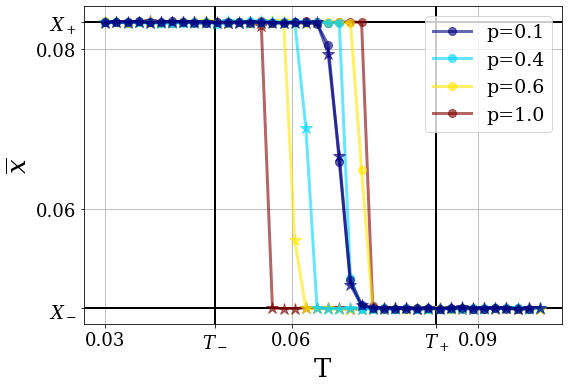

In [306]:
size = 26
alpha = 0.6

alpha_2 = 0.4

plt.figure(figsize=(8,5.5))

plt.axhline(xplus, c='k', lw=2)
plt.axhline(xminus, c='k', lw=2)

plt.axvline(Tminus, c='k', lw=2)
plt.axvline(Tplus, c='k', lw=2)

to_print = [0, 3, 4, 6]
p_to_print = [ps[i] for i in to_print]
results_to_print = [results[i] for i in to_print]
cmap = plt.cm.get_cmap('jet', len(results_to_print))

for i, res in enumerate(results_to_print):
    # increasing T with dots
    plt.plot(res[0][:len(res[0])//2], res[1][:len(res[0])//2], 'o-', label='p='+str(p_to_print[i]), c=cmap(i), ms=8, lw=3, alpha=alpha, zorder=100-i)
    # decreasing T with stars
    plt.plot(res[0][len(res[0])//2:], res[1][len(res[0])//2:], '*-', c=cmap(i), ms=12, lw=3, alpha=alpha, zorder=100-i)
    
plt.xlabel('T')
plt.ylabel(r'$\overline{x}$')

xpos = np.arange(0.06, 0.09, 0.02)
xtick = np.round(xpos,3).astype(str)
xpos = list(xpos) + [xminus, xplus]
xtick = list(xtick) + [r'$X_-$', r'$X_+$']

ypos = np.arange(0.03, 0.11, 0.03)
ytick = np.round(ypos,3).astype(str)
ypos = list(ypos) + [Tminus, Tplus]
ytick = list(ytick) + [r'$T_-$', r'$T_+$']

plt.yticks(ticks = xpos, labels=xtick)
plt.xticks(ticks = ypos, labels=ytick)

#plt.yticks(fontsize=size-8)
#plt.xticks(fontsize=size-8)
    
plt.legend(fontsize=size-7, loc='upper right')
plt.grid()

#plt.show()
plt.tight_layout()
plt.savefig('figures/act_various_p.pdf')

# Power spectrum - Connectome

In [11]:
N = W.shape[0]
dt = 0.01
steps = int(1e4)

Ts = [0.5*Tminus, Tminus + 0.5*(Tplus-Tminus), 2.*Tplus]
titles = [r'$T<T_-$', r'$T_-<T<T_+$', r'$T>T_+$']

In [26]:
res = []

# Run model
for i, T in enumerate(Ts):
    print(i)
    x, y = run_htc_single(W, xplus, yplus, T, r1, r2, dt, steps, N=N, runs=30)
    
    res.append(x)

0
1
2


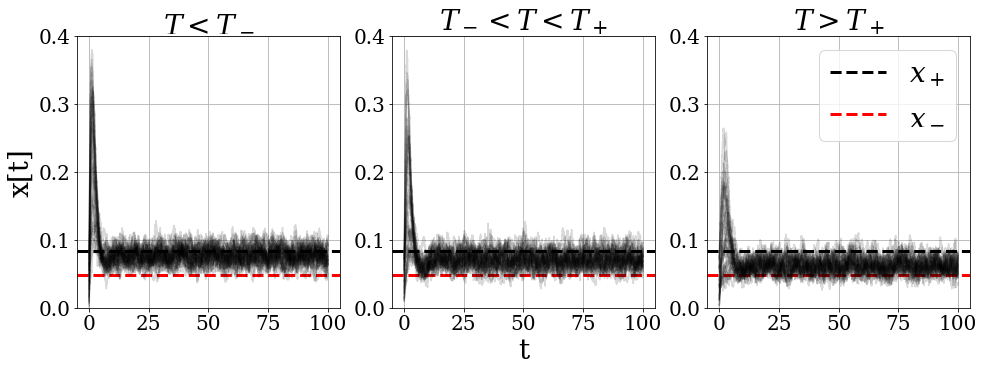

In [27]:
size = 28

plt.figure(figsize=(16,5))

for i, T in enumerate(Ts):
    #print('T='+str(T))

    #x, y = run_htc_single(None, xplus, yminus, T, r1, r2, dt, steps, N=N, runs=30)
        
    plt.subplot(1, len(Ts), i+1)
    
    plt.locator_params(nbins=5)
    
    plt.axhline(xplus, ls='--', c='k', label=r'$x_+$', lw=3)
    plt.axhline(xminus, ls='--', c='r', label=r'$x_-$', lw=3)
        
    for series in res[i]:
        plt.plot(np.arange(0,steps)*dt, series, alpha=0.15, c='k')
        
    plt.title(titles[i], size=size)
    
    plt.ylim([0,.4])
        
    if i == 0:
        plt.ylabel('x[t]', size=size)
            
    if i == len(Ts)-2:
        plt.xlabel('t', size=size)
        
    if i == len(Ts)-1:
        plt.legend(fontsize=size)
    
    plt.xticks(fontsize=size-8)
    plt.yticks(fontsize=size-8)
    plt.grid()
        
#plt.show()
#plt.savefig("figures/trajectories.pdf")

In [28]:
for i, x in enumerate(res):
    np.save('results/traj_sample_connectome_'+str(i)+'.npy', x)

In [13]:
N = W.shape[0]
dt = 0.01
steps = int(1e5)

Ts = [0.*Tminus, Tminus + 0.5*(Tplus-Tminus), 10.*Tplus]
titles = [r'$T<T_-$', r'$T_-<T<T_+$', r'$T>T_+$']

In [21]:
res_spec = []

# Run model
for i, T in enumerate(Ts):
    print(i)
    
    x, y = run_htc_single(W, xplus, yplus, T, r1, r2, dt, steps, N=N, runs=30, eq_steps=int(50/dt))
    
    res_spec.append(x)

0
1
2


In [24]:
for i, res in enumerate(res_spec):
    np.save('results/N_'+str(N)+'_dt_'+str(dt)+'_steps_'+str(steps)+'_T_'+str(Ts[i])+'connectome.npy', res)

In [14]:
res_spec = []

for i, T in enumerate(Ts):
    tmp = np.load('results/N_'+str(N)+'_dt_'+str(dt)+'_steps_'+str(steps)+'_T_'+str(Ts[i])+'connectome.npy')
    res_spec.append(tmp)

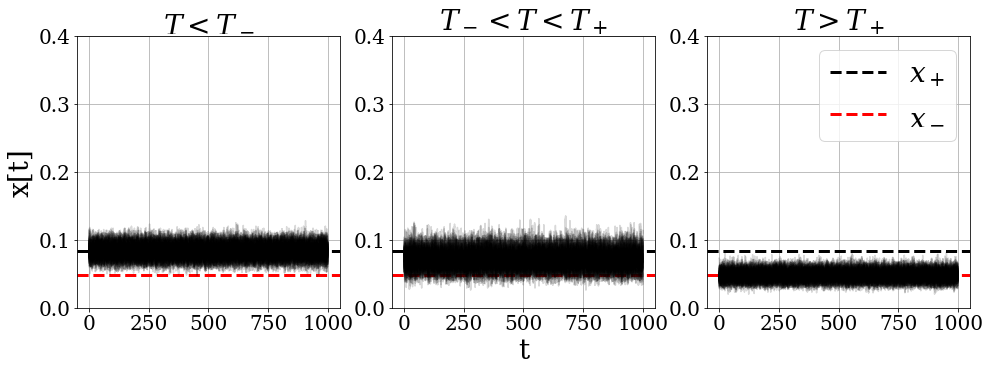

In [22]:
size = 28
lw=5

plt.figure(figsize=(16,5))

for i, T in enumerate(Ts):

    ax = plt.subplot(1, len(Ts), i+1)
    
    for x in res_spec[i]:
        f, S = my_power_spectrum(x, dt, nperseg=int(3e3))
    
        plt.plot(2*np.pi*f, S, c='k', alpha=0.1)

    plt.plot(2*np.pi*f, Psup(2*np.pi*f,r1,r2) / N / 0.5, '--', label=r'$P_+^{th}$', lw=lw, c='blue')
    plt.plot(2*np.pi*f, Psub(2*np.pi*f,r1,r2) / N / 0.5, '--', label=r'$P_-^{th}$', lw=lw, c='r')
        
    plt.xlabel(r'$\omega$')
    if i==0:
        plt.ylabel(r'$P(\omega)$')
        
    plt.title(titles[i], size=size)
    plt.locator_params(nbins=4)
    plt.xscale('log')
    plt.yscale('log')
    
    plt.axvline(w_max(r1, r2), c='k', ls='--', alpha=0.6)
    
    ax.text(0.18, -0.08, r'$\omega_-^{max}$',transform=ax.transAxes, size=20)
    
    #plt.text(-7, 1, 'coap')
    
    #plt.xticks(fontsize=size-14)
    #plt.yticks(fontsize=size-14)
    
    if i < len(Ts)-1:
        ax.yaxis.set_ticklabels([])
    else:
        ax.yaxis.tick_right()
    
    plt.grid()
    
    if i==len(Ts)-1:
        plt.legend(fontsize=size-4)
        
    plt.xlim([1e-1, 1e1])
    plt.ylim([1e-7, 8e-6])

#plt.show()
plt.tight_layout()
plt.savefig("figures/spectrum.pdf")

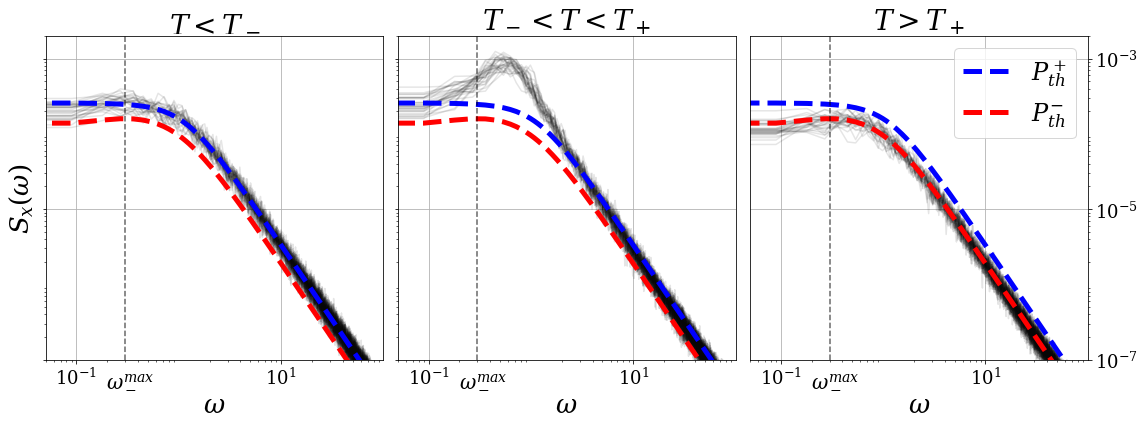

In [15]:
size = 28
lw=5

plt.figure(figsize=(16,6))

for i, T in enumerate(Ts):

    ax = plt.subplot(1, len(Ts), i+1)
    
    
    spectra = []
    
    for x in res_spec[i]:
        f, S = my_power_spectrum(x, dt, nperseg=int(7e3))
    
        plt.plot(2*np.pi*f, S, c='k', alpha=0.1)

    plt.plot(2*np.pi*f, Psup(2*np.pi*f,r1,r2) / N / 0.5, '--', label=r'$P_{th}^+$', lw=lw, c='blue')
    plt.plot(2*np.pi*f, Psub(2*np.pi*f,r1,r2) / N / 0.5, '--', label=r'$P_{th}^{-}$', lw=lw, c='r')
    
    plt.xlabel(r'$\omega$')
    if i==0:
        plt.ylabel(r'$S_x(\omega)$')
        
    plt.title(titles[i], size=size)
    
    plt.locator_params(nbins=3)
    plt.xscale('log')
    plt.yscale('log')
    
    plt.grid()
    
    plt.yticks(np.array([1e-3, 1e-5, 1e-7]))
    plt.xticks(np.array([1e-1, 1e1]))
    #plt.yticks(fontsize=size-14)
    
    plt.axvline(w_max(r1, r2), c='k', ls='--', alpha=0.6)
    ax.text(0.18, -0.08, r'$\omega_-^{max}$',transform=ax.transAxes, size=20)
    
    if i < len(Ts)-1:
        ax.yaxis.set_ticklabels([])
    else:
        ax.yaxis.tick_right()
    
    if i==len(Ts)-1:
        plt.legend(fontsize=size-4)
        
    plt.xlim([5e-2, 1e2])
    plt.ylim([1e-7, 2e-3])

#plt.show()
plt.tight_layout()
plt.savefig("figures/spectrum_connectome.pdf")